In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [74]:
intra = pd.read_csv('data_truncada_1m.csv',parse_dates=[2],sep=',',na_values='NA')

In [75]:
intra.tail()

,Unnamed: 0,name,times,type,value,size,dia,dia.1,BID,ASK,Mid_price,Quoted_spread,bid_depth,ask_depth,depth,Quote_spread
649496,649497,BCOLO CB Equity,2017-08-31 15:54:39,TRADE,32000,415.0,2017-08-31,2017-08-31,31900.0,32000.0,31950.0,0,614.0,56282.0,17.35812,0.00313
649497,649498,BCOLO CB Equity,2017-08-31 15:54:39,TRADE,32000,970.0,2017-08-31,2017-08-31,31900.0,32000.0,31950.0,0,614.0,56282.0,17.35812,0.00313
649498,649499,BCOLO CB Equity,2017-08-31 15:54:39,TRADE,32000,4315.0,2017-08-31,2017-08-31,31900.0,32000.0,31950.0,0,614.0,56282.0,17.35812,0.00313
649499,649500,BCOLO CB Equity,2017-08-31 15:54:54,ASK,32000,40582.0,2017-08-31,2017-08-31,31900.0,32000.0,31950.0,0,614.0,40582.0,17.03107,0.00313
649500,649501,BCOLO CB Equity,2017-08-31 15:54:57,TRADE,32000,5000.0,2017-08-31,2017-08-31,31900.0,32000.0,31950.0,0,614.0,40582.0,17.03107,0.00313


In [76]:
intra=intra.drop(['Unnamed: 0','dia','dia.1','Quoted_spread'],axis=1)

In [77]:
intra.columns=['nombre','date_time','tipo','precio','volumen','bid','ask','mid_price','bid_depth','ask_depth','depth','quote_spread']

In [78]:
intra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649501 entries, 0 to 649500
Data columns (total 12 columns):
nombre          649501 non-null object
date_time       649501 non-null datetime64[ns]
tipo            649501 non-null object
precio          649501 non-null int64
volumen         649501 non-null float64
bid             619327 non-null float64
ask             619327 non-null float64
mid_price       619327 non-null float64
bid_depth       619327 non-null float64
ask_depth       619327 non-null float64
depth           619327 non-null float64
quote_spread    619327 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 59.5+ MB


In [79]:
# lectura de las acciones
acciones = pd.read_csv("ACCIONES 1m.csv")
acciones = pd.DataFrame(acciones)
acciones2 = acciones[["x"]]+" CB Equity"
#x =x.between_time('9:30','15:55')


In [80]:
#### Volumen ####

0.0 18.0


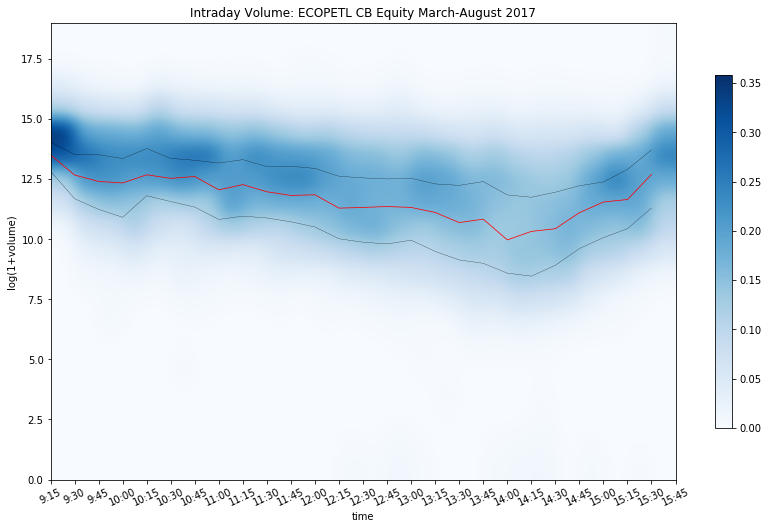

0.0 15.0


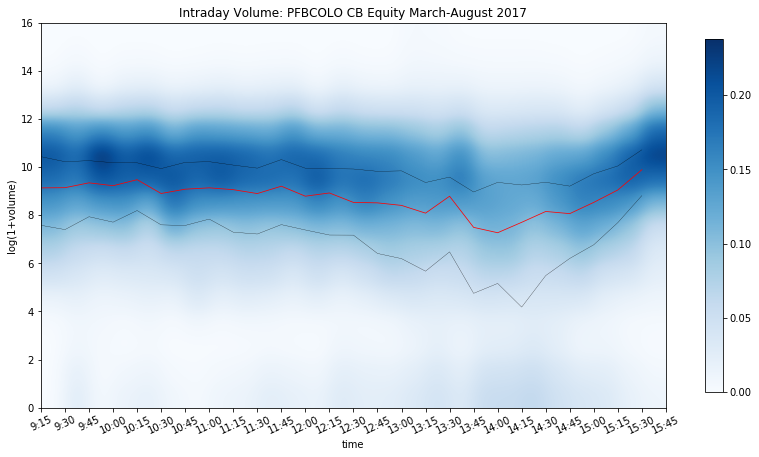

0.0 17.0


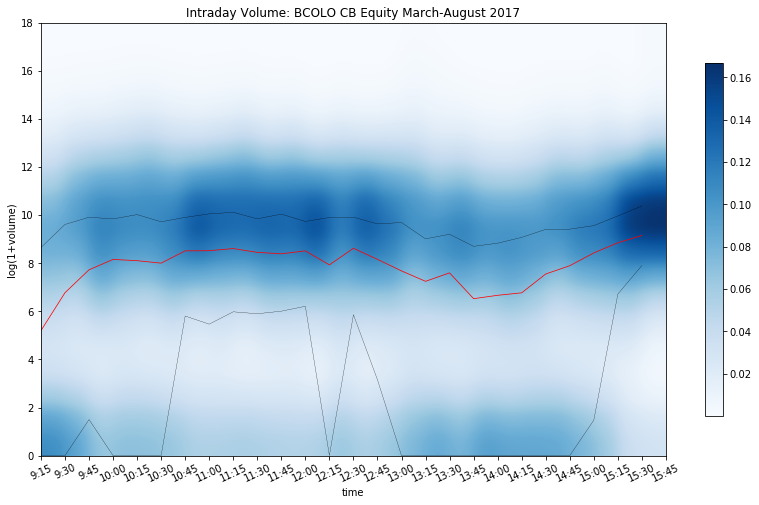

In [81]:
for i in range(0, 3):
    x = intra[intra.nombre == str(acciones2.iloc[i,0])]
    # x = intra[intra.nombre == nameshare]
    x.index = x.date_time
    x = x.drop('date_time', axis =1)
    #x =x.between_time('9:30','15:55')
    x1 = x[x.tipo == "TRADE"]
       
    vol15min = x1.volumen.resample("15T").sum().fillna(value=0)
    
    vol15min=vol15min.between_time('9:00','15:45')
    vol15min=vol15min.reset_index()
    
    vol15min['date']=pd.to_datetime(vol15min.date_time.dt.date)
    vol15min['time']=vol15min.date_time.dt.time
    
    #Create Business days Colombia
    weekmask='Mon Tue Wed Thu Fri'
    holydays=[pd.datetime(2017, 1, 9),pd.datetime(2017, 3, 20),pd.datetime(2017, 4, 13),
    pd.datetime(2017, 4, 14),pd.datetime(2017, 5, 1),pd.datetime(2017, 5, 29),
    pd.datetime(2017, 6, 19),pd.datetime(2017, 6, 26),pd.datetime(2017, 7, 3),
    pd.datetime(2017, 7, 20),pd.datetime(2017, 8, 7),pd.datetime(2017, 8, 21),
    pd.datetime(2017, 10, 16),pd.datetime(2017, 11, 6),pd.datetime(2017, 11, 13),
    pd.datetime(2017, 12, 8),pd.datetime(2017, 12, 25)]
    BdaysCol2017=pd.bdate_range(start=pd.datetime(2017, 1, 1),end=pd.datetime(2017, 12, 31),
                         weekmask=weekmask,holidays=holydays)
    
    vol15minF=vol15min[vol15min.date.isin(BdaysCol2017)]
    vol15minF=vol15minF.drop(['date','time'],axis=1)

    #pivot
    vol15minF=vol15minF.pivot_table(index=[vol15minF.date_time.dt.date, vol15minF.date_time.dt.time]).unstack(1)
    
    #log (volume +1)
    vol15minP=np.log(vol15minF.iloc[:,2:]+1)
    
    #Eliminate days with all 0, why do these exist Bloomberg error, preguntar Catalina
    vol15minP=vol15minP[vol15minP.sum(1)!=0]
    
    #Hallar mediana y cuantiles 
    volmedian=vol15minP.median(0)
    volq25=vol15minP.quantile(q=0.25,axis=0)
    volq75=vol15minP.quantile(q=0.75,axis=0)
    
    #estimate Kernel density for each timestamp column using historical data
    Gmax=np.rint(vol15minP.values.max())
    Gmin=np.rint(vol15minP.values.min())
    print(Gmin,Gmax)
    
    y = int(Gmax + 1)
    
    #interval to visualize density
    lvols=np.arange(start=Gmin,stop=Gmax+1,step=1)
    
    XX=vol15minP.as_matrix()
    
    densM=[]
    for k in range(XX.shape[1]):
        kde = stats.gaussian_kde((XX[:,k]))
        densM.append(kde(lvols))      
        
    vol15minD=pd.DataFrame(np.reshape(densM,(26,y)).transpose(), index=lvols,columns=vol15minP.columns)
    
    rvol15minD = vol15minD.iloc[::-1]
    rvol15minD.index=np.flipud(lvols)
    
    timelab=('9:15','9:30','9:45','10:00','10:15','10:30','10:45','11:00',
        '11:15','11:30','11:45','12:00','12:15','12:30','12:45','13:00','13:15',
        '13:30','13:45','14:00','14:15','14:30','14:45','15:00','15:15','15:30','15:45')
    
    # Graficar #
    
    fig = plt.figure(figsize=(14,10))
    plt.imshow(rvol15minD.values,cmap=plt.cm.Blues,interpolation='gaussian',
          extent=[0, 26, 0, y], vmax=rvol15minD.values.max(), vmin=rvol15minD.values.min())
    plt.colorbar(shrink=0.65)
    plt.plot(volmedian.values,color='red',linewidth=0.75)
    plt.plot(volq25.values,color='black',linewidth=0.25)
    plt.plot(volq75.values,color='black',linewidth=0.25)
    plt.grid(b='off')
    plt.ylabel('log(1+volume)')
    plt.xlabel('time')
    plt.title('Intraday Volume: ' + str(acciones2.iloc[i,0]) + ' March-August 2017')
    #plt.title('Intraday Volume: ' + nameshare + ' March-August 2017')
    plt.xticks(np.arange(27),timelab, rotation=25)
    #fig.savefig( nameshare + ' volumen' + '.png')
    fig.savefig( str(acciones2.iloc[i,0]) + ' volumen' + '.png')
    plt.show()


In [82]:
#### Depth ####

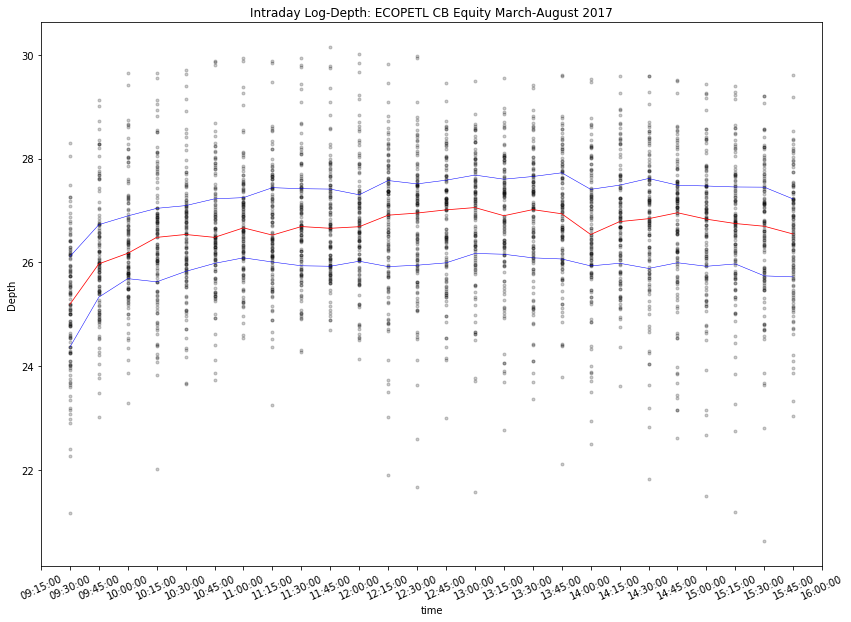

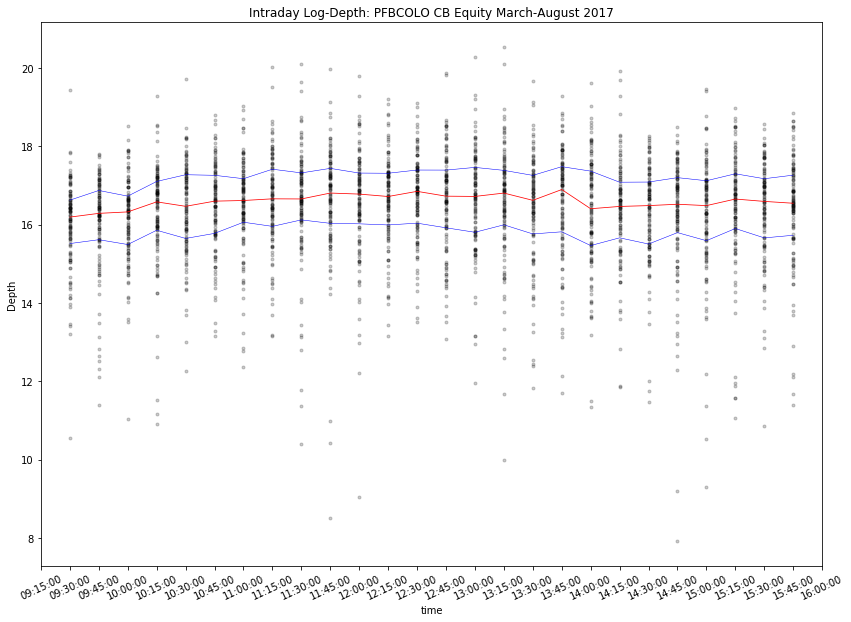

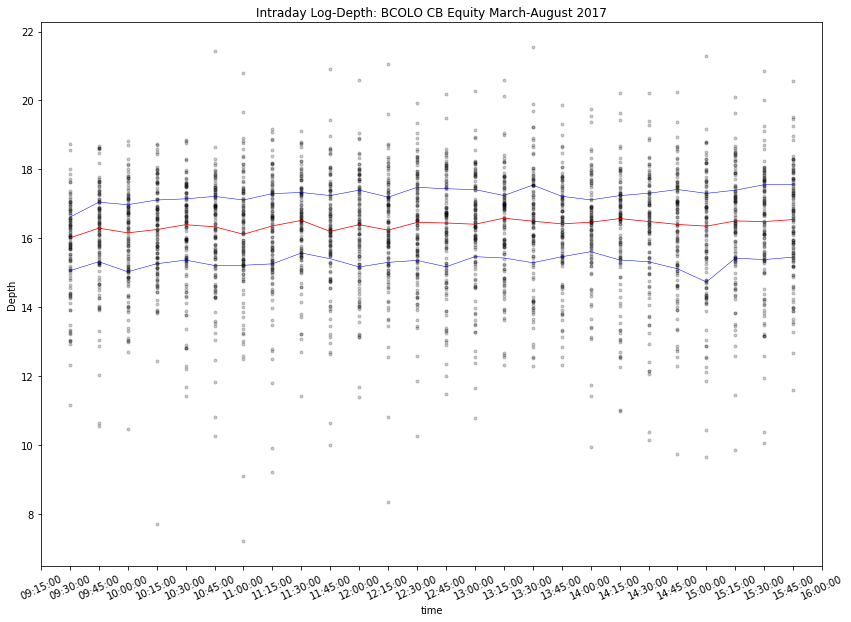

In [87]:
-


In [ ]:
## Spread ##

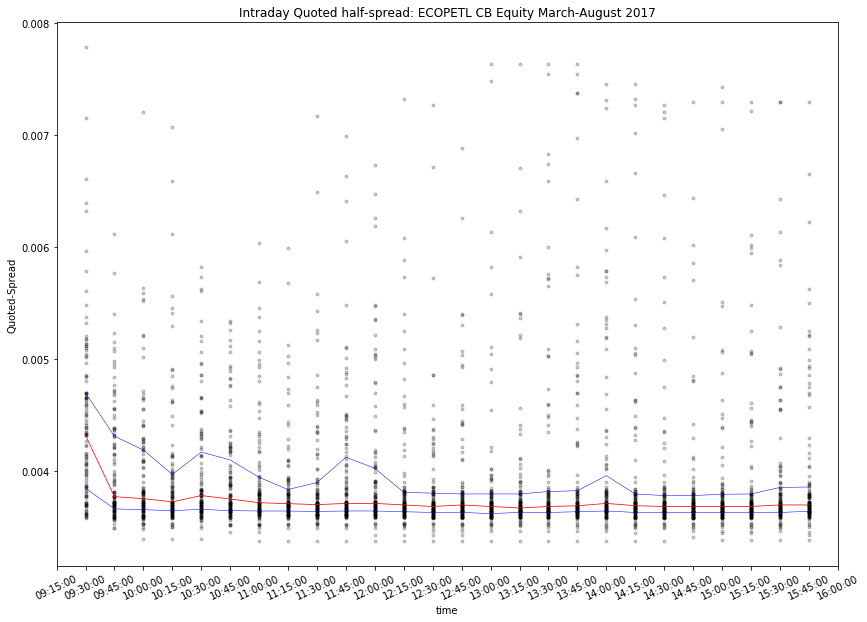

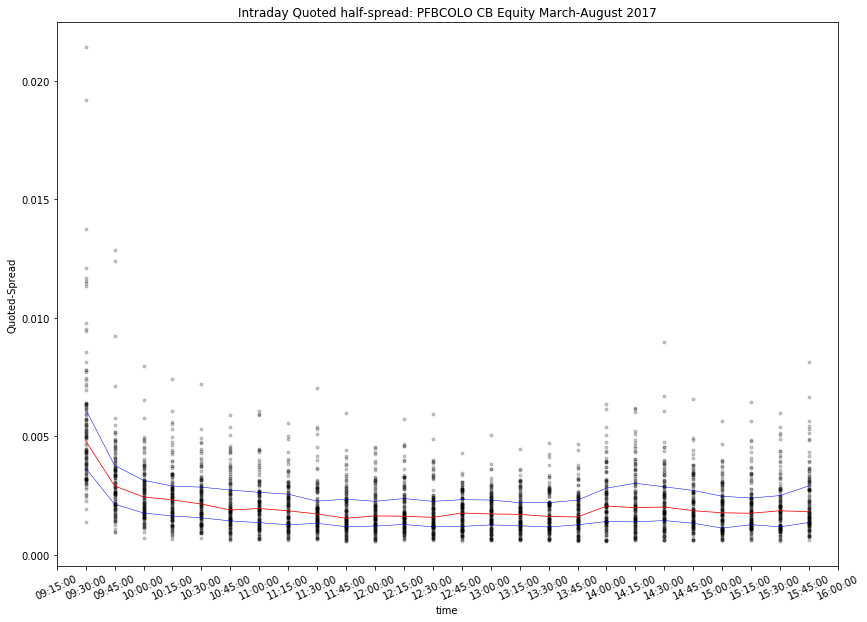

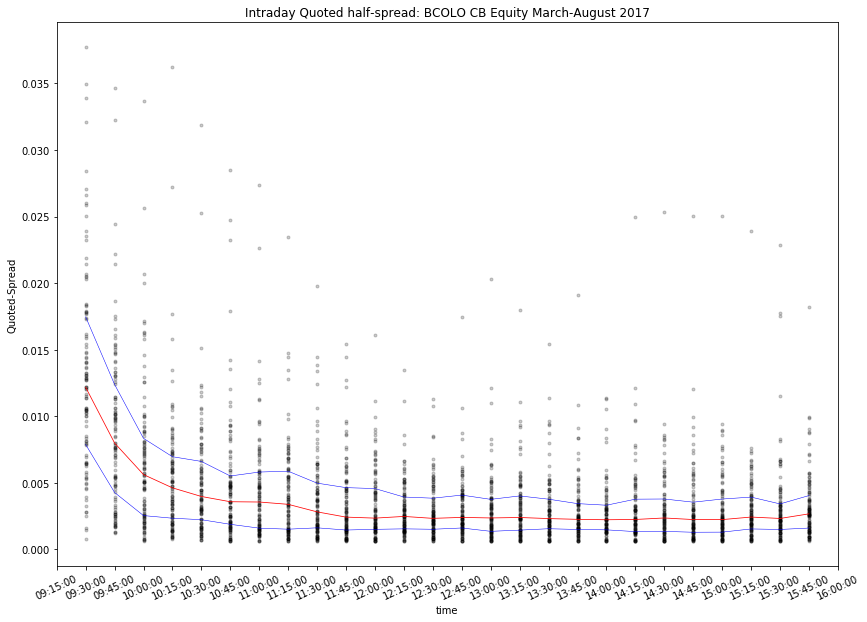

In [92]:
for i in range(0, 3):
    
    x = intra[intra.nombre == str(acciones2.iloc[i,0])]
    # x = intra[intra.nombre == nameshare]
    x.index = x.date_time
    x = x.drop('date_time', axis =1)
    #x =x.between_time('9:30','15:55')
           
    spread15min = x.quote_spread.resample("15T").mean()
    
    spread15min=spread15min.between_time('9:30','15:45')
    spread15min=spread15min.reset_index()
    
    spread15min['date']=pd.to_datetime(spread15min.date_time.dt.date)
    spread15min['time']=spread15min.date_time.dt.time
    
   #Create Business days Colombia

    weekmask='Mon Tue Wed Thu Fri'
    holydays=[pd.datetime(2017, 1, 9),pd.datetime(2017, 3, 20),pd.datetime(2017, 4, 13),
    pd.datetime(2017, 4, 14),pd.datetime(2017, 5, 1),pd.datetime(2017, 5, 29),
    pd.datetime(2017, 6, 19),pd.datetime(2017, 6, 26),pd.datetime(2017, 7, 3),
    pd.datetime(2017, 7, 20),pd.datetime(2017, 8, 7),pd.datetime(2017, 8, 21),
    pd.datetime(2017, 10, 16),pd.datetime(2017, 11, 6),pd.datetime(2017, 11, 13),
    pd.datetime(2017, 12, 8),pd.datetime(2017, 12, 25)]
    BdaysCol2017=pd.bdate_range(start=pd.datetime(2017, 1, 1),end=pd.datetime(2017, 12, 31),
                         weekmask=weekmask,holidays=holydays)
    
    spread15minF=spread15min[spread15min.date.isin(BdaysCol2017)]
    
    spread15minF=spread15minF.drop(['date','time'],axis=1)
    
    #pivot
    spread15minF=spread15minF.pivot_table(index=[spread15minF.date_time.dt.time, spread15minF.date_time.dt.date]).unstack(1)
    
   
    #Eliminate days with all 0, why do these exist Bloomberg error, preguntar Catalina
    spread15minF=spread15minF[spread15minF.sum(1)!=0]
    
    #Hallar mediana y cuantiles 
    spreadmedian=spread15minF.median(1)
    spreadq25=spread15minF.quantile(q=0.25,axis=1)
    spreadq75=spread15minF.quantile(q=0.75,axis=1)


    indice = spread15minF.index
    spreadmedian.index = indice
    spreadq25.index=indice
    spreadq75.index=indice
             
   
    timelab=('9:15','9:30','9:45','10:00','10:15','10:30','10:45','11:00',
        '11:15','11:30','11:45','12:00','12:15','12:30','12:45','13:00','13:15',
        '13:30','13:45','14:00','14:15','14:30','14:45','15:00','15:15','15:30','15:45','16:00')
    
    #Graficar#

    spread15minF.plot(legend=None, style='k.',alpha=0.2, figsize=(14,10))
    spreadmedian.plot(legend=None,color='red',linewidth=0.75)
    spreadq25.plot(legend=None,color='blue',linewidth=0.5)
    spreadq75.plot(legend=None,color='blue',linewidth=0.5)
    plt.ylabel('Quoted-Spread')
    plt.xlabel('time')
    plt.title('Intraday Quoted half-spread: ' + str(acciones2.iloc[i,0]) + ' March-August 2017')
    plt.xticks(timelab, rotation=25)
    plt.savefig( str(acciones2.iloc[i,0]) + ' quoted-spread' + '.png')
    plt.show()

In [93]:
### Volatility ###

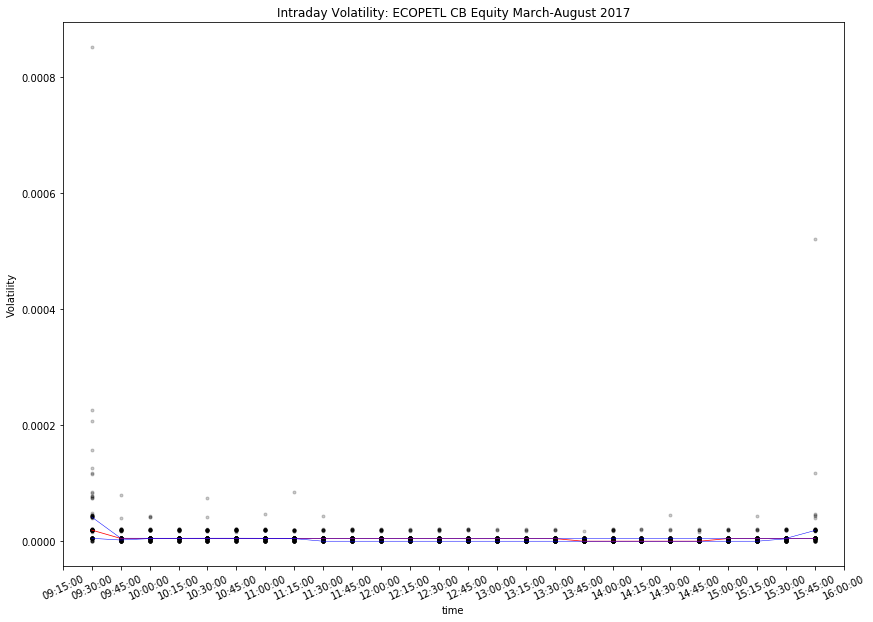

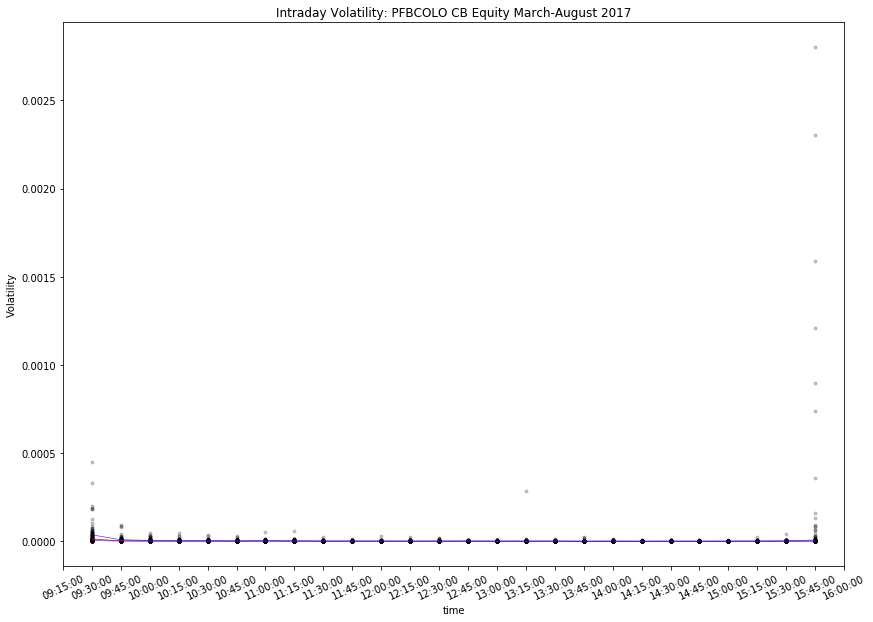

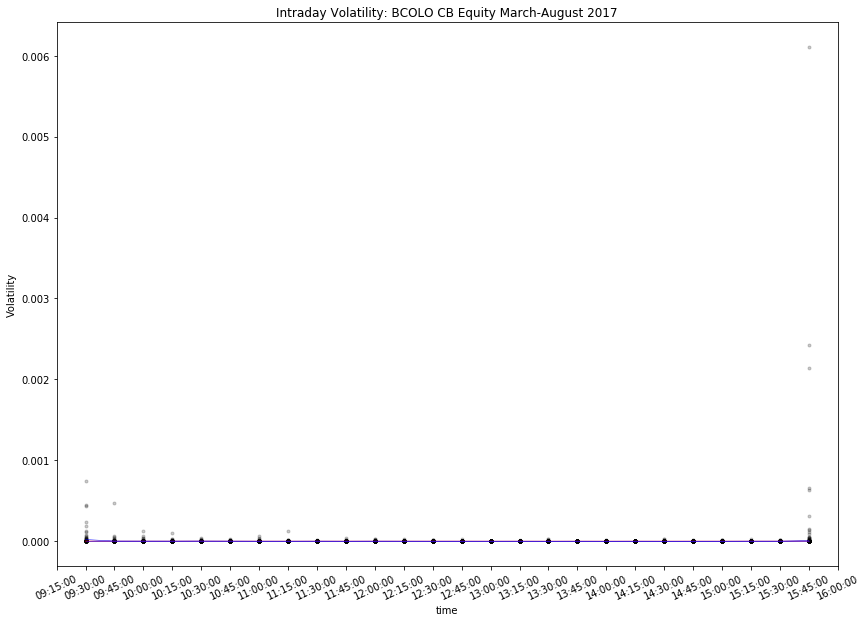

In [94]:
for i in range(0, 3):
    
    x = intra[intra.nombre == str(acciones2.iloc[i,0])]
    # x = intra[intra.nombre == nameshare]
    x.index = x.date_time
    x = x.drop('date_time', axis =1)
    #x =x.between_time('9:30','15:55')
    x1 = x[x.tipo == "TRADE"]
    
    vol15max =  x1.precio.resample("15T").max()
    vol15min =  x1.precio.resample("15T").min()
    logmax = np.log(vol15max)
    logmin = np.log(vol15min)
    
    vola15min = ((logmax - logmin)**2)/(4*np.log(2)) 
    
    vola15min=vola15min.between_time('9:30','15:45')
    vola15min=vola15min.reset_index()
    
    vola15min['date']=pd.to_datetime(vola15min.date_time.dt.date)
    vola15min['time']=vola15min.date_time.dt.time
    
   #Create Business days Colombia

    weekmask='Mon Tue Wed Thu Fri'
    holydays=[pd.datetime(2017, 1, 9),pd.datetime(2017, 3, 20),pd.datetime(2017, 4, 13),
    pd.datetime(2017, 4, 14),pd.datetime(2017, 5, 1),pd.datetime(2017, 5, 29),
    pd.datetime(2017, 6, 19),pd.datetime(2017, 6, 26),pd.datetime(2017, 7, 3),
    pd.datetime(2017, 7, 20),pd.datetime(2017, 8, 7),pd.datetime(2017, 8, 21),
    pd.datetime(2017, 10, 16),pd.datetime(2017, 11, 6),pd.datetime(2017, 11, 13),
    pd.datetime(2017, 12, 8),pd.datetime(2017, 12, 25)]
    BdaysCol2017=pd.bdate_range(start=pd.datetime(2017, 1, 1),end=pd.datetime(2017, 12, 31),
                         weekmask=weekmask,holidays=holydays)
    
    vola15minF=vola15min[vola15min.date.isin(BdaysCol2017)]
    
    vola15minF=vola15minF.drop(['date','time'],axis=1)
    
    #pivot
    vola15minF=vola15minF.pivot_table(index=[vola15minF.date_time.dt.time, vola15minF.date_time.dt.date]).unstack(1)
    
   
    #Eliminate days with all 0, why do these exist Bloomberg error, preguntar Catalina
    vola15minF=vola15minF[vola15minF.sum(1)!=0]
    
    #Hallar mediana y cuantiles 
    volamedian=vola15minF.median(1)
    volaq25=vola15minF.quantile(q=0.25,axis=1)
    volaq75=vola15minF.quantile(q=0.75,axis=1)


    indice = vola15minF.index
    volamedian.index = indice
    volaq25.index=indice
    volaq75.index=indice
             
   
    timelab=('9:15','9:30','9:45','10:00','10:15','10:30','10:45','11:00',
        '11:15','11:30','11:45','12:00','12:15','12:30','12:45','13:00','13:15',
        '13:30','13:45','14:00','14:15','14:30','14:45','15:00','15:15','15:30','15:45','16:00')
    
    #Graficar#

    vola15minF.plot(legend=None, style='k.',alpha=0.2, figsize=(14,10))
    volamedian.plot(legend=None,color='red',linewidth=0.75)
    volaq25.plot(legend=None,color='blue',linewidth=0.5)
    volaq75.plot(legend=None,color='blue',linewidth=0.5)
    plt.ylabel('Volatility')
    plt.xlabel('time')
    plt.title('Intraday Volatility: ' + str(acciones2.iloc[i,0]) + ' March-August 2017')
    plt.xticks(timelab, rotation=25)
    plt.savefig( str(acciones2.iloc[i,0]) + ' volatility' + '.png')
    plt.show()